In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from torchvision.models import vit_b_16
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

%run helpFunction.ipynb

In [2]:
class VerkehrsschilderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for label, subfolder in enumerate(['y', 'n']):
            folder_path = os.path.join(self.root_dir, subfolder)
            for image_name in os.listdir(folder_path):
                self.images.append(os.path.join(folder_path, image_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformationen definieren
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(15),
    transforms.RandomGrayscale(p=0.2),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset erstellen
dataset = VerkehrsschilderDataset('data', transform=transform)

total_count = len(dataset)
train_count = int(0.7 * total_count)
valid_count = int(0.15 * total_count)
test_count = total_count - train_count - valid_count  # Adjust to ensure all data is used

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_count, valid_count, test_count])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
class_names = ['Wartelinie', 'keine Wartelinie']

In [3]:
print(total_count)
VerkehrsschilderDataset.__getitem__(dataset, 900)

1456


(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


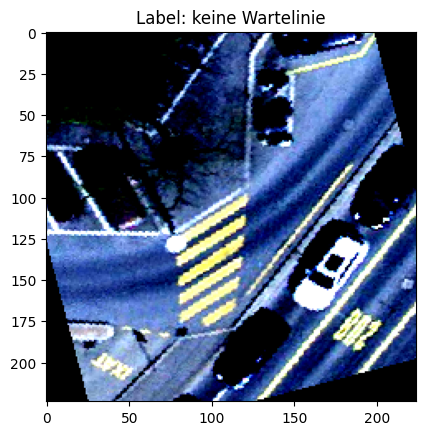

In [4]:
def show_image(image, label):
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.title('Label: ' + ('Wartelinie' if label == 0 else 'keine Wartelinie'))
    plt.show()

show_image(VerkehrsschilderDataset.__getitem__(dataset, 900)[0], VerkehrsschilderDataset.__getitem__(dataset, 900)[1])

In [5]:
class CustomViT(nn.Module):
    def __init__(self):
        super(CustomViT, self).__init__()

        self.vit = vit_b_16(pretrained=True)
        
        self.num_features = self.vit.heads[0].in_features

        self.vit.heads[0] = nn.Identity()

        self.fc1 = nn.Linear(self.num_features, self.num_features)
        self.bn1 = nn.BatchNorm1d(self.num_features)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(self.num_features, 2)

    def forward(self, x):
        x = self.vit(x)  
        x = self.fc1(x)
        x = self.bn1(x)  
        x = self.relu(x)  
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [6]:
model = CustomViT()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Verlustfunktion und Optimierer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc2.parameters(), lr=0.001, weight_decay=0.01)  # Adding weight decay
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

c:\Users\csang\miniconda3\envs\fhgr\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\csang\miniconda3\envs\fhgr\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
def validate_model(model, criterion, valid_loader):
    model.eval()
    validation_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    validation_loss = validation_loss / len(valid_loader)
    validation_accuracy = 100 * correct / total
    
    print(f'Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')
    return validation_loss, validation_accuracy


In [8]:
def train_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs=5, patience=3):
    model.train()
    best_val_loss = float('inf')
    patience_counter = 0
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%')
        
        val_loss, val_accuracy = validate_model(model, criterion, valid_loader)

        history['train_loss'].append(epoch_loss)
        history['train_accuracy'].append(epoch_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)


        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epochs.")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
    return history

In [9]:
def evaluate_model(model, criterion, test_loader, class_names):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())
    
    test_loss /= len(test_loader)
    accuracy = 100 * correct / total

    prediction_csv(all_labels, all_preds, 'VisionTransformer')

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')


In [10]:
history = train_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs=25)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_accuracy'], label='Train')
plt.plot(history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

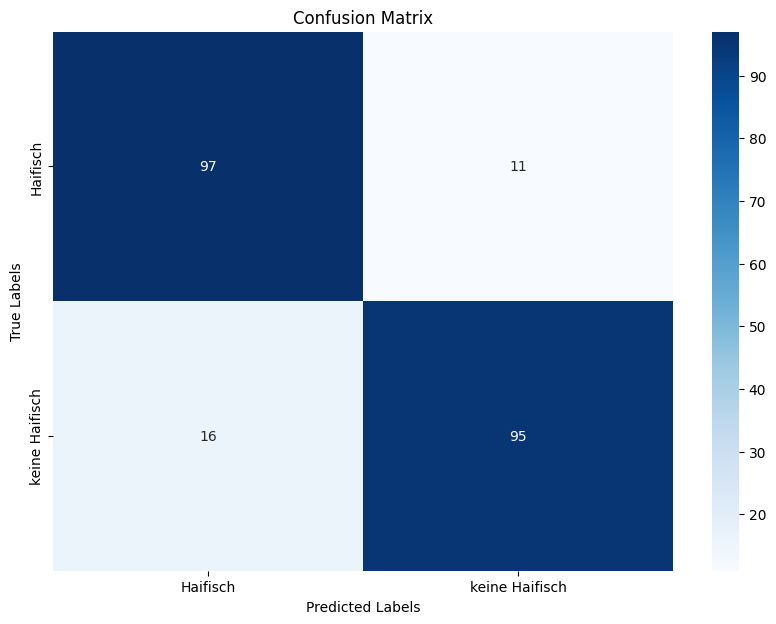

Test Loss: 0.3397, Test Accuracy: 87.67%


In [ ]:
evaluate_model(model, criterion, test_loader, class_names)
print(evaluate_model(model, criterion, test_loader, class_names))

In [ ]:
#plot die falsch klassifizierten Bilder
def plot_misclassified_images(model, test_loader):
    model.eval()
    misclassified_images = []
    correct_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            misclassified_indices = (predicted != labels).nonzero()
            for mis_ind in misclassified_indices:
                misclassified_images.append(images[mis_ind].cpu())
                correct_labels.append(labels[mis_ind].cpu())
                predicted_labels.append(predicted[mis_ind].cpu())

    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(np.transpose(misclassified_images[i], (1, 2, 0)))
        plt.axis('off')
        plt.title(f'Actual: {class_names[correct_labels[i]]}\nPredicted: {class_names[predicted_labels[i]]}')
    plt.tight_layout()
    plt.show()

In [ ]:
plot_misclassified_images(model, test_loader)

In [ ]:
def predict_image(image, model):
    model.eval()
    image_tensor = transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = image_tensor.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

image = Image.open('data/image.png').convert('RGB')

index = predict_image(image, model)
print(f'Prediction: {class_names[index]}')

Prediction: keine Haifisch
